In [2]:
%matplotlib notebook
import os
import pickle
import datetime
import calendar
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from apiclient.datahub import datahub_main
from apiclient.dataset import dataset
from shapely.geometry.polygon import Polygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm.notebook import tqdm
from Datahub_example_for_construction_v2 import dataset_coverages, read_raster_data_to_json, dataset_resolutions

plt.rcParams['figure.figsize'] = (6,4)

# Wind climatology at different heights above ground. Case study using ERA5, KNMI Harmonie and meteorological observations data.


## Introduction

In this notebook we will introduce **Planet OS Datahub (by Intertrust)** by using datasets that could be relevant for any use case, where wind data between levels 10m .. 300m is required and possibly some observation data exists. 

There may be several use cases for such data, but most of them seem to be related to wind energy production or construction, where men or machines need to operate at elevated heights, raising safety concerns.

Interest in the data is often related to forecasts (how much energy can we produce next day, is it safe to work on a high altitude) or climatology (how much energy do I produce in a year, how often is my construction work disturbed). 

However, few people pay attention, that different model based datasets may differ significantly. Especially for highly variable parameters like wind speed, which is not just dependent on the model configuration, but is highly influenced by local conditions.

We will use 10 m and 100 m wind variables from [ECMWF ERA5](https://data.planetos.com/datasets/ecmwf_era5_v2) for long history (1979-near real time) and [KNMI Harmonie forecast](https://data.planetos.com/datasets/knmi_harmonie_europe) model (2019 Oct - now). KNMI Harmonie also has wind data from 10 m, 50 m, 100 m, 200 m and 300 m. 

In this example we will:
- illustrate different available datasets by coverages and resolution, discovery
- show how to query data from Datahub
- show how to find out on how many days in year wind speed exceeds certain threshold (20 m/s at this case)
- we will visualize the results
- show monthly distribution on how many days over 40 years wind speed has exceeded the threshold. 
- show normal distribution and weibull distribution graphs
- show differences between models with higher and lower resolution, and compare them to actual station data

- show how to read forecast data as continious timeseries dataset
- make graph with KNMI Harmonie and ECMWF ERA5 daily average wind speeds using plotly, where one can zoom in to have closer look into data
- find daily wind speed difference [%] between two datasets
- find correlation between two datasets
- make weibull distribution graphs for 2020 from ERA5 and KNMI datasets
- query wind speed at 10 m observation data and compare it with forecast

## Discovering datasets
Datahub provies dataset search and filtering functionality in the page https://data.planetos.com/datasets 
Here we just illustrate, how different weather forecast datasets differ by spatial coverage, horizontal and vertical resolution and available time period.

* ERA5 is a reanalysis dataset, meaning it is created for climatological studies, and covers long time ranges (currently 1979-2021, but will also contain data from 1950 onwards). But it's structure is very similar to weather forecast dataset.
* KNMI Harmonie is a high resolution weather forecast dataset created by the Royal Met Office of Netherlands. Currently, Datahub provides history of the dataset from Nov 2019

Just for comparison, we also show
* MeteoFrance Harmonie, high-resolution weather forecast dataset for France, added for comparison.
* NOAA NAM, weather forecast for US main land

In order to access data in Datahub, you need to provide an API key. You can find your API key if you are logged in and go https://data.planetos.com/account/settings/. In this example, we store the key in a file **APIKEY** and keep it in the same folder as running code. 

In [3]:
API_key = open('APIKEY').read().strip()

In [4]:
dh=datahub_main(API_key)
era5_dataset = dataset('ecmwf_era5_v2',dh)
knmi_dataset = dataset('knmi_harmonie_europe',dh)
rbsn_dataset = dataset('noaa_rbsn_timeseries',dh)

did not update apikey


### Dataset coverages

ERA5 is global dataset, but KNMI Harmonie is regional and covers part of Europe. Let's see which part - marked with green.

MeteoFrance Arome is marked with yellow and North American Mesoscale Forecast System (NAM): CONUS Nest (grey).

<IPython.core.display.Javascript object>


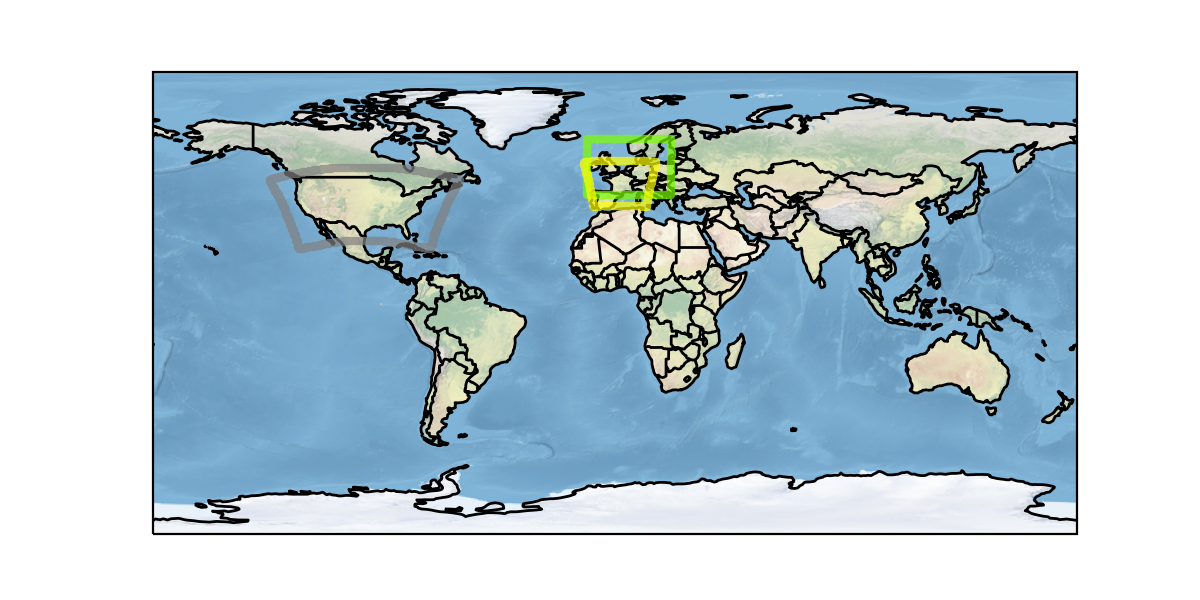

In [5]:
dataset_coverages(dh)

### Dataset resolutions
Limited area (weather/climate) models exist, because computational resources usually do not permit higher resolutions for global models. Below we show the resolution difference of model local weather model compared to global reanalysis.

http://api.planetos.com/v1/datasets/knmi_harmonie_europe/area?apikey=8428878e4b944abeb84790e832c633fc&polygon=[[2,52],[7,52],[7,55],[2,55],[2,52]]&grouping=location&count=1&reftime_recent=true&var=u_wind_height_above_ground&reftime_start=2021-01-01T00:00:00&time=2021-01-01T01:00:00
http://api.planetos.com/v1/datasets/ecmwf_era5_v2/area?apikey=8428878e4b944abeb84790e832c633fc&polygon=[[2,52],[7,52],[7,55],[2,55],[2,52]]&grouping=location&count=1&reftime_recent=true&var=eastward_wind_at_10_metres&time_start=2021-01-01T01:00:00


<IPython.core.display.Javascript object>


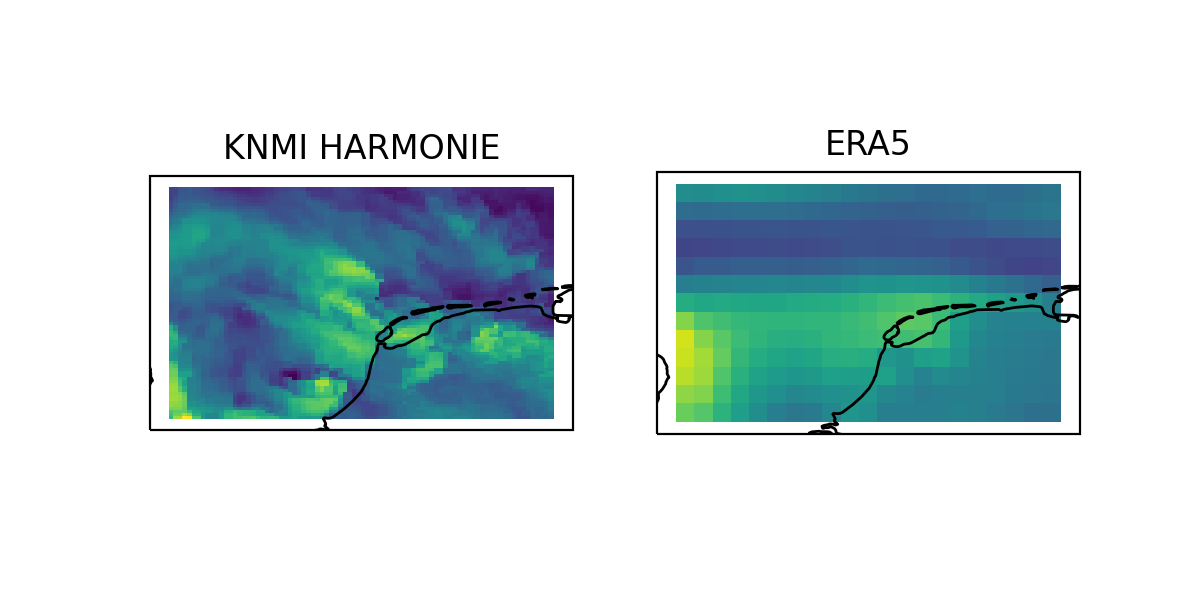

In [6]:
dataset_resolutions(API_key)

## Accessing the data
Here we will define datasets to use. As said before, we will use [ECMWF ERA5](https://data.planetos.com/datasets/ecmwf_era5_v2) and [KNMI Harmonie forecast](https://data.planetos.com/datasets/knmi_harmonie_europe). If you would like to browse other dataset, you can use our [discovery page](https://data.planetos.com/datasets).

We use a simple dh_py_access library for controlling REST requests, but using our API is not restricted by any particular programming language.

Define your desired location. We choose a weather station near Liverpool as first point and location of a marine wind farm in the Irist sea, as a second station, and get data for year 2020 for these.

## Fetch and reorganize the data
For ERA5, we get all available timerange, for KNMI, we get the year 2020 so we can compare it to ERA5. 
Station data will also be received for the year 2020, but at 10 m height only.

### Station selection and fetching

In [7]:
start_delta=550
st_id = '03321'
rbsn_data = rbsn_dataset.get_station_data_as_pandas([st_id], count=30000, variables = ['wind_speed'],start_delta=start_delta)[st_id]
rbsn_data=rbsn_data[rbsn_data.index.year==2020]
rbsn_data_daily = rbsn_data.resample("1D").max()['wind_speed']

In [8]:
len(rbsn_data_daily)

366

In [9]:
lon_lats = [rbsn_dataset.stations()['station'][st_id]['SpatialExtent']['coordinates'], [-3.5, 53.5]]

### KNMI Harmonie
Now we will look into historic KNMI Harmonie forecasts, which have the advantage of better spatial resolution. It covers most of France and part of Europe, centered over Netherlands. KNMI Harmonie data archive available at Planet OS datahub starts from Nov, 2019 and we will construct a continuous time series from it, so we can compare it to the ECMWF wind speed.
We need to define the z parameter, as KNMI has wind speed on different heights. z=2 means 100 meters.
To be noted, 10m z=0, 50m z=1, 100m z=2, 200m z=3 and 300m z=4.

KNMI Harmonie is a forecast dataset, meaning it has a different `reference time` for each time when model is runned. To analyse historical data, we first read full forecasts for all reference times and the convert it to a continuouts timeseries.

#### KNMI Reference time demo

##### Fetch data, one day = four reftimes

In [10]:
%%time
vars_knmi = 'u_wind_height_above_ground,v_wind_height_above_ground'; z = 2

reftime_start = datetime.datetime(2021,3,24)
reftime_end = datetime.datetime(2021,3,24,18)
knmi_reftime_demo = knmi_dataset.get_json_data_in_pandas(
    lon=lon_lats[0][0],lat=lon_lats[0][1],
    start=reftime_start.isoformat(),
    end=(reftime_end+datetime.timedelta(hours=48)).isoformat(),
    reftime_start=reftime_start.isoformat(),
    reftime_end=reftime_end.isoformat(),
    count=4*48,vars=vars_knmi,z=z
)

CPU times: user 37.6 ms, sys: 5.19 ms, total: 42.8 ms
Wall time: 6.48 s


<IPython.core.display.Javascript object>


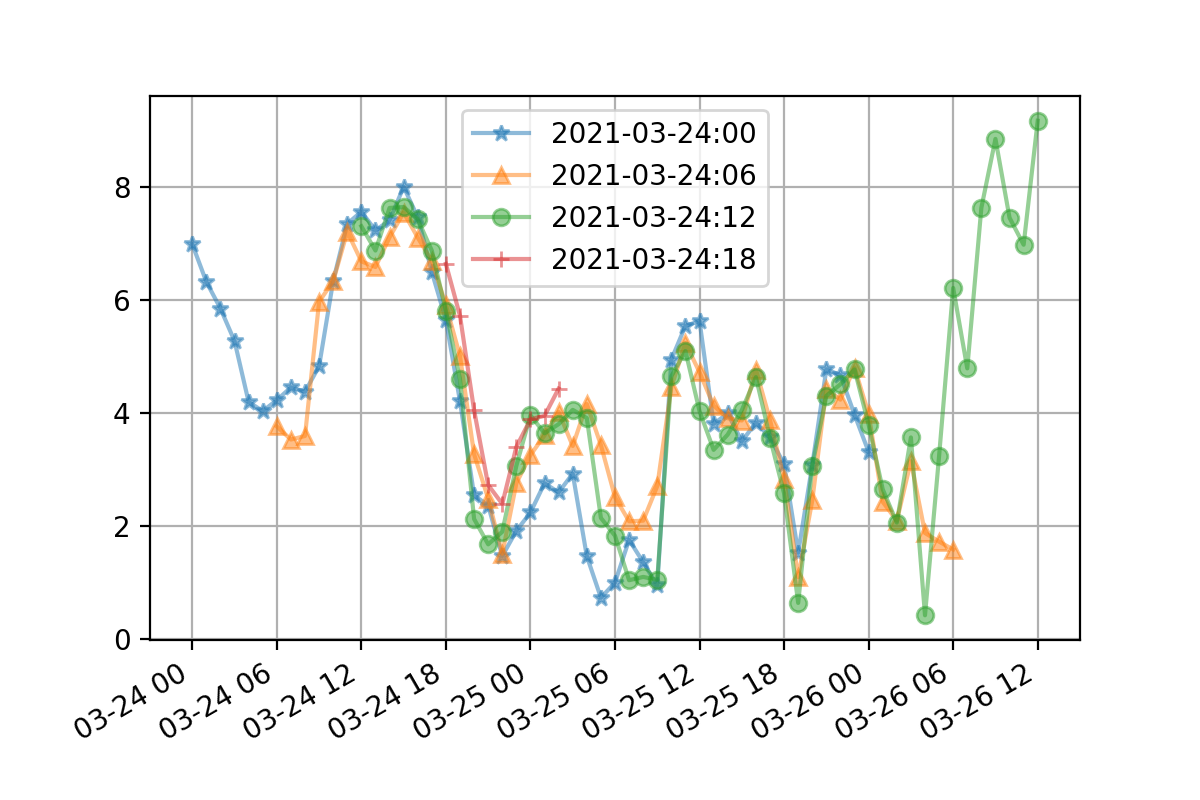

In [11]:
fig = plt.figure()
markers = ['*-','^-','o-','+-']
for e,rt in enumerate(knmi_reftime_demo['reftime'].unique()):
    ddd = knmi_reftime_demo[knmi_reftime_demo['reftime']==rt ]
    plt.plot(ddd['time'],ddd['u_wind_height_above_ground'], markers[e], label=pd.to_datetime(rt).strftime("%Y-%m-%d:%H"), alpha=0.5)
plt.legend()
fig.autofmt_xdate()
plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


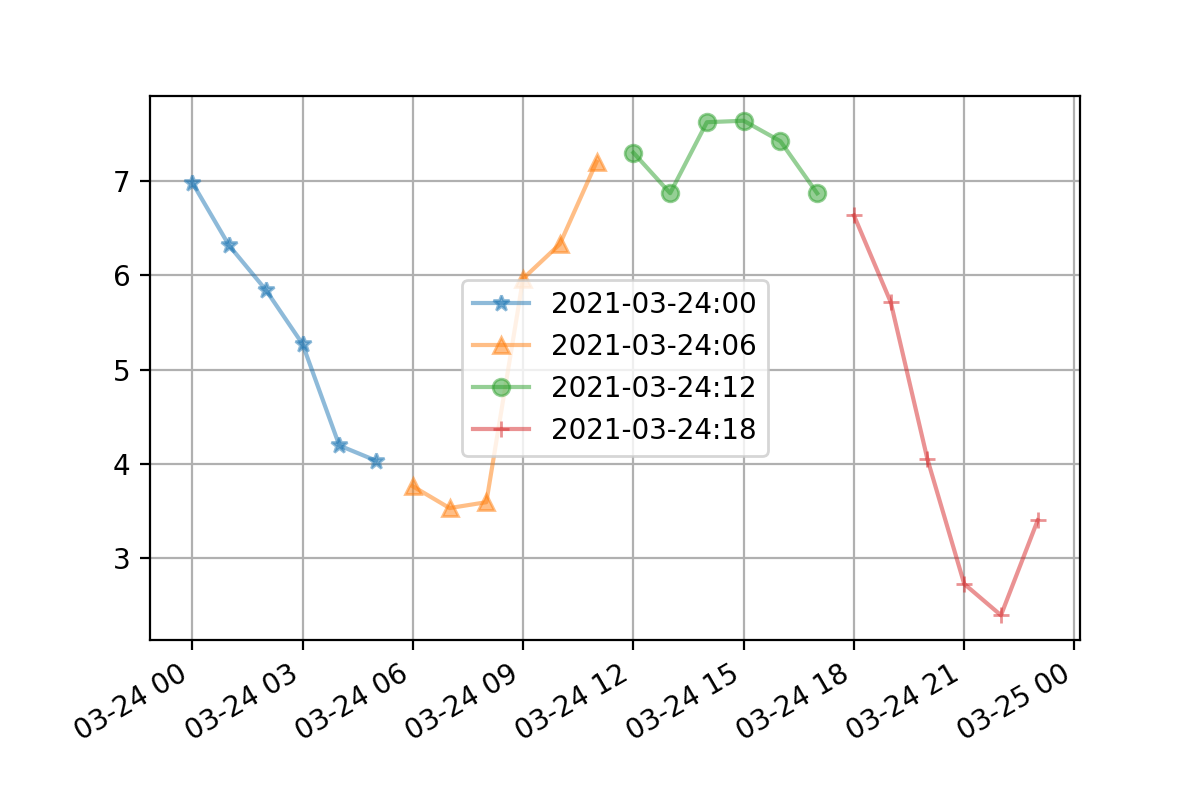

In [12]:
fig = plt.figure()
markers = ['*-','^-','o-','+-']
for e,rt in enumerate(knmi_reftime_demo['reftime'].unique()):
    ddd = knmi_reftime_demo[(knmi_reftime_demo['reftime']==rt) & (
        knmi_reftime_demo['time'] - knmi_reftime_demo['reftime'] < datetime.timedelta(hours=6))]
    plt.plot(ddd['time'],ddd['u_wind_height_above_ground'], markers[e], 
             label=pd.to_datetime(rt).strftime("%Y-%m-%d:%H"), alpha=0.5)
plt.legend()
fig.autofmt_xdate()
plt.legend()
plt.grid()
plt.show()


### ERA5 
As requesting 40 year data at once would be overwhelming for the API, we will request data year by year. The data is saved to local file so if you have downloaded it once, it will not be fetched again.

In [13]:
%%time
ERA5_keys = ['ERA5_40_years_Liverpool', 'ERA5_40_years_windfarm']

ERA5 = {i:None for i in ERA5_keys}

for e, era5_file in enumerate(ERA5):
    if os.path.exists(era5_file+".pickle"):
        ERA5[era5_file] = pickle.load(open(era5_file+".pickle",'rb'))
    else:
        year_start = 1979; year_end = 2020
        def fcall(year):
            return {'lon':lon_lats[e][0],
                   'lat':lon_lats[e][1],
                   'start':str(year) + '-01-01T00:00:00',
                   'end':str(year) + '-12-31T23:00:00',
                   'count':10000,
                   'vars':'eastward_wind_at_100_metres,northward_wind_at_100_metres,eastward_wind_at_10_metres,northward_wind_at_10_metres'}
        ERA5[era5_file] = pd.concat(
            [era5_dataset.get_json_data_in_pandas(**fcall(year)) 
             for year in tqdm(range(year_start, year_end + 1))]).set_index('time')
        pickle.dump(ERA5[era5_file], open(era5_file+".pickle",'wb'))

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

CPU times: user 1min 20s, sys: 453 ms, total: 1min 20s
Wall time: 16min 9s


In [14]:
%%time
KNMI_keys = ['KNMI_2020_Liverpool','KNMI_2020_windfarm']
KNMI = {i:None for i in KNMI_keys}
def get_reft(reft, lon, lat):
    reft_end = datetime.datetime(
        reft.year, reft.month,calendar.monthrange(reft.year,reft.month)[1])
    ttt=knmi_dataset.get_json_data_in_pandas(
        lon=lon,
        lat=lat,
        start=reft.isoformat(),
        end=(reft_end+datetime.timedelta(hours=5)).isoformat(),
        reftime_start=reft.isoformat(),
        reftime_end=reft_end.isoformat(),
        count=33*24*2,
        vars='u_wind_height_above_ground,v_wind_height_above_ground',
        z='all')
    return ttt[
        (ttt['time'] - ttt['reftime']) < datetime.timedelta(hours=6)][
        ['reftime','time','u_wind_height_above_ground','v_wind_height_above_ground','z']]

for e, knmi_file in enumerate(KNMI):
    if os.path.exists(knmi_file+".pickle"):
        KNMI[knmi_file] = pickle.load(open(knmi_file+".pickle", 'rb'))
    else:
        KNMI[knmi_file] = pd.concat(
            [get_reft(reftime,lon_lats[e][0],lon_lats[e][1]) for reftime in tqdm(pd.date_range(
                datetime.datetime(2020,1,1),
                datetime.datetime(2020,12,31,18),freq='MS'))]).set_index('time')
        pickle.dump(KNMI[knmi_file], open(knmi_file+".pickle",'wb'))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 2min 9s, sys: 598 ms, total: 2min 9s
Wall time: 11min 34s


### Converting wind components
The data for wind speed is given as two components, but we really need the total wind speed and do not care about the direction. As the data layout is different for the climatological and forecast datasets, we need to compute them separately.

In [15]:
for wind in ERA5:
    for level in [10, 100]:
        ERA5[wind]['wind_speed_at_{}_metres'.format(level)] = np.sqrt(
            ERA5[wind]['northward_wind_at_{}_metres'.format(level)]**2 + 
            ERA5[wind]['eastward_wind_at_{}_metres'.format(level)]**2)
    ERA5[wind] = ERA5[wind][['wind_speed_at_{}_metres'.format(level) for level in [10,100]]]

For KNMI we can skip one step, as level is already given as a separate column.

In [16]:
for wind in KNMI:
    print(wind)
    KNMI[wind]['wind_speed'] = np.sqrt(
        KNMI[wind]['u_wind_height_above_ground']**2 + KNMI[wind]['v_wind_height_above_ground']**2)
    KNMI[wind]=KNMI[wind][KNMI[wind]['z'].isin([10,100])][['z','wind_speed']]

KNMI_2020_Liverpool
KNMI_2020_windfarm


Here we will find daily maximums:

In [17]:
KNMI_dmax = {knmi_file:KNMI[knmi_file].groupby('z').resample('D').max().droplevel('z') for knmi_file in KNMI_keys}

In [18]:
KNMI_dmax[KNMI_keys[0]]

z  wind_speed
time                         
2020-01-01   10.0    4.854513
2020-01-02   10.0    8.242441
2020-01-03   10.0    8.119938
2020-01-04   10.0    6.430125
2020-01-05   10.0    5.997290
...           ...         ...
2020-12-27  100.0   19.618016
2020-12-28  100.0   10.621479
2020-12-29  100.0    9.394608
2020-12-30  100.0    9.067353
2020-12-31  100.0    7.770033

[732 rows x 2 columns]

<IPython.core.display.Javascript object>


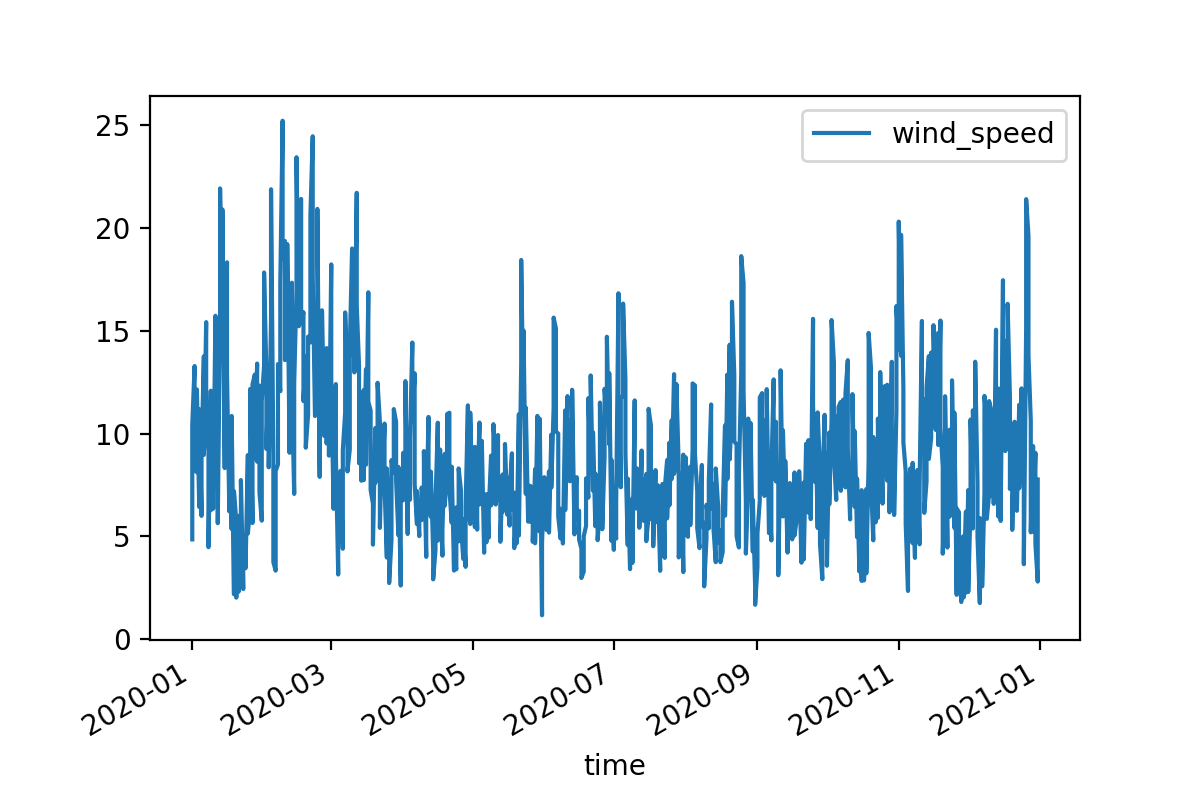

<AxesSubplot:xlabel='time'>

In [19]:
KNMI_dmax[KNMI_keys[0]][['wind_speed']].plot()

In [20]:
wind_threshold = 20
ERA5_dmax = {era5_file:ERA5[era5_file].resample('D').max() for era5_file in ERA5.keys()}
ERA5_annual = {era5_file:ERA5_dmax[era5_file].apply(lambda x: x> wind_threshold).resample("1Y").sum() for era5_file in ERA5.keys()}

## Visualizing the data

### ERA5 40-year data for two locations
We plot the number of days with wind over threshold in two locations. As expected, the wind speeds are significantly higher over the sea, and we also observe a strong year to year variability. Wind speed at 10m is also significantly lower than at 100 metres.

<IPython.core.display.Javascript object>


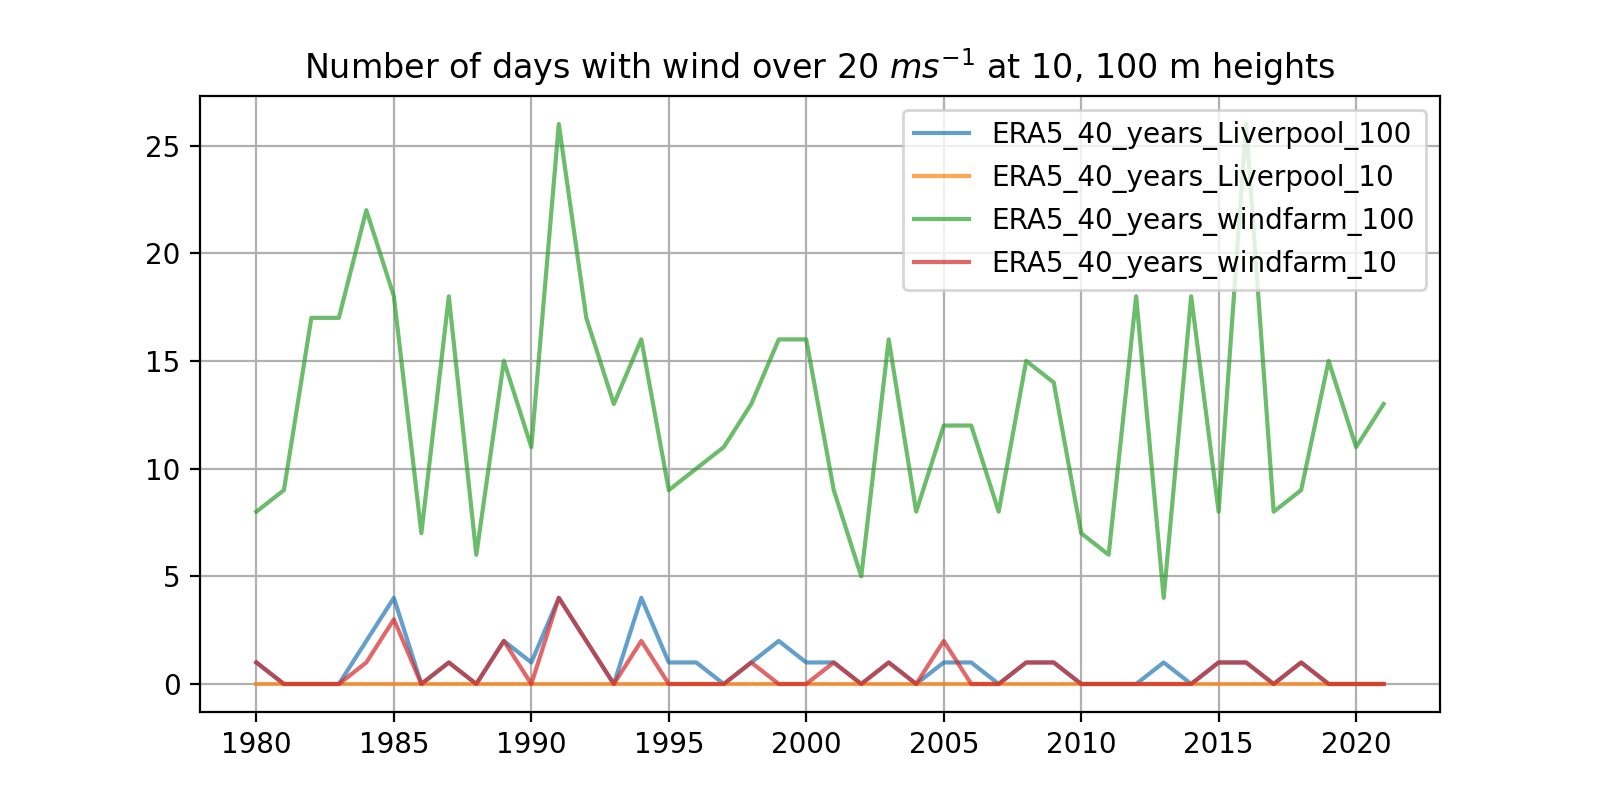

In [21]:
fig, ax =plt.subplots(1,1,figsize=(8,4))
for st in ERA5_keys:
    ax.plot(ERA5_annual[st]['wind_speed_at_100_metres'], label=st+'_100', alpha=0.7)
    ax.plot(ERA5_annual[st]['wind_speed_at_10_metres'], label=st+'_10', alpha=0.7)
plt.legend()
plt.title("Number of days with wind over 20 $ms^{-1}$ at 10, 100 m heights")
plt.grid()
# plt.savefig("presentation_nr_of_days_over_20_at_100", bbox_inches='tight', transparent=True)

#### Seasonal distribution of strong winds

Below we will find out on which months wind speed exceeds 20 m/s mostly. We can clearly see how winter months have more wind. 

<IPython.core.display.Javascript object>


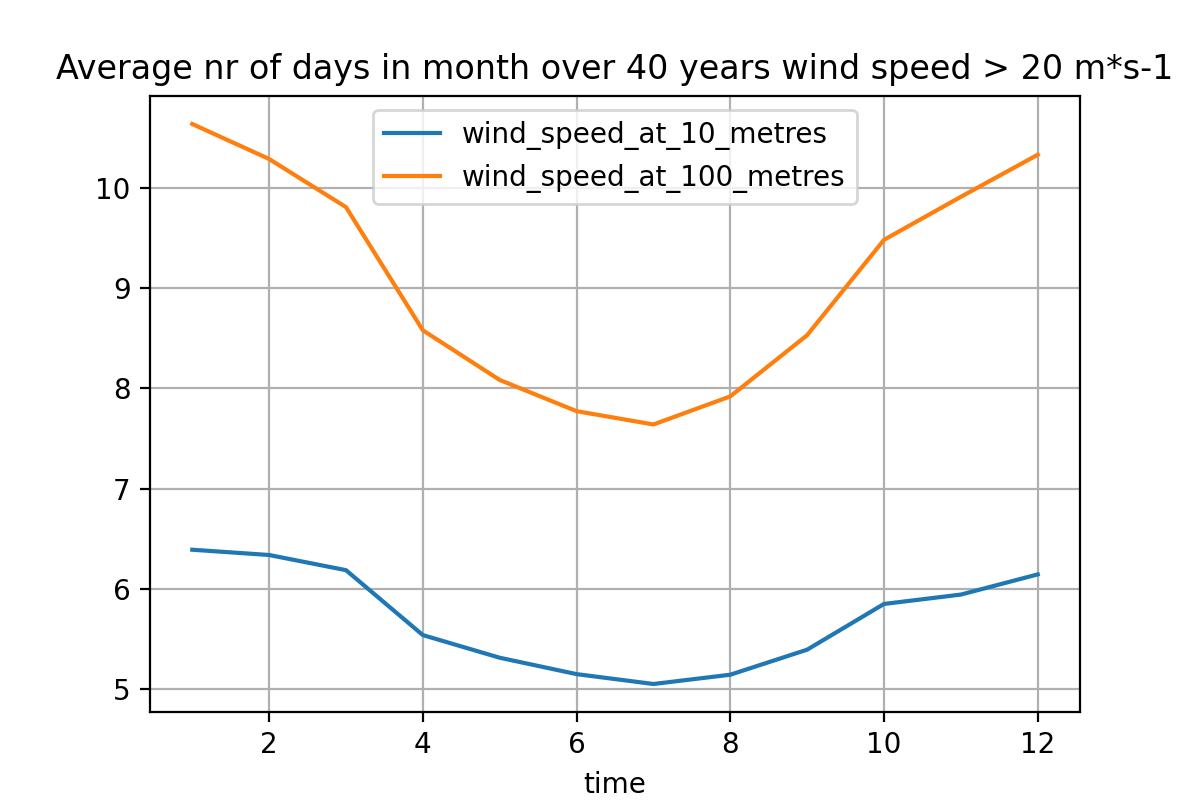

In [22]:
p=ERA5_dmax['ERA5_40_years_Liverpool'].groupby(ERA5_dmax['ERA5_40_years_Liverpool'].index.month).mean().plot()
p.title.set_text(f'Average nr of days in month over 40 years wind speed > {wind_threshold} m*s-1')
p.grid()

### 2020 ERA5-KNMI comparison
We expect the higher resolution model, KNMI HARMONIE, to have better performance on describing the wind conditions, which are affected by local surface features like buildings, mountains, forests, etc. If we are able to determine systematic bias between the two, we might expect to be able to make corrections to the 40-year climatology as well.

Simple line plot shows that models are similar, but this is not a good way to illustrate the difference

<IPython.core.display.Javascript object>


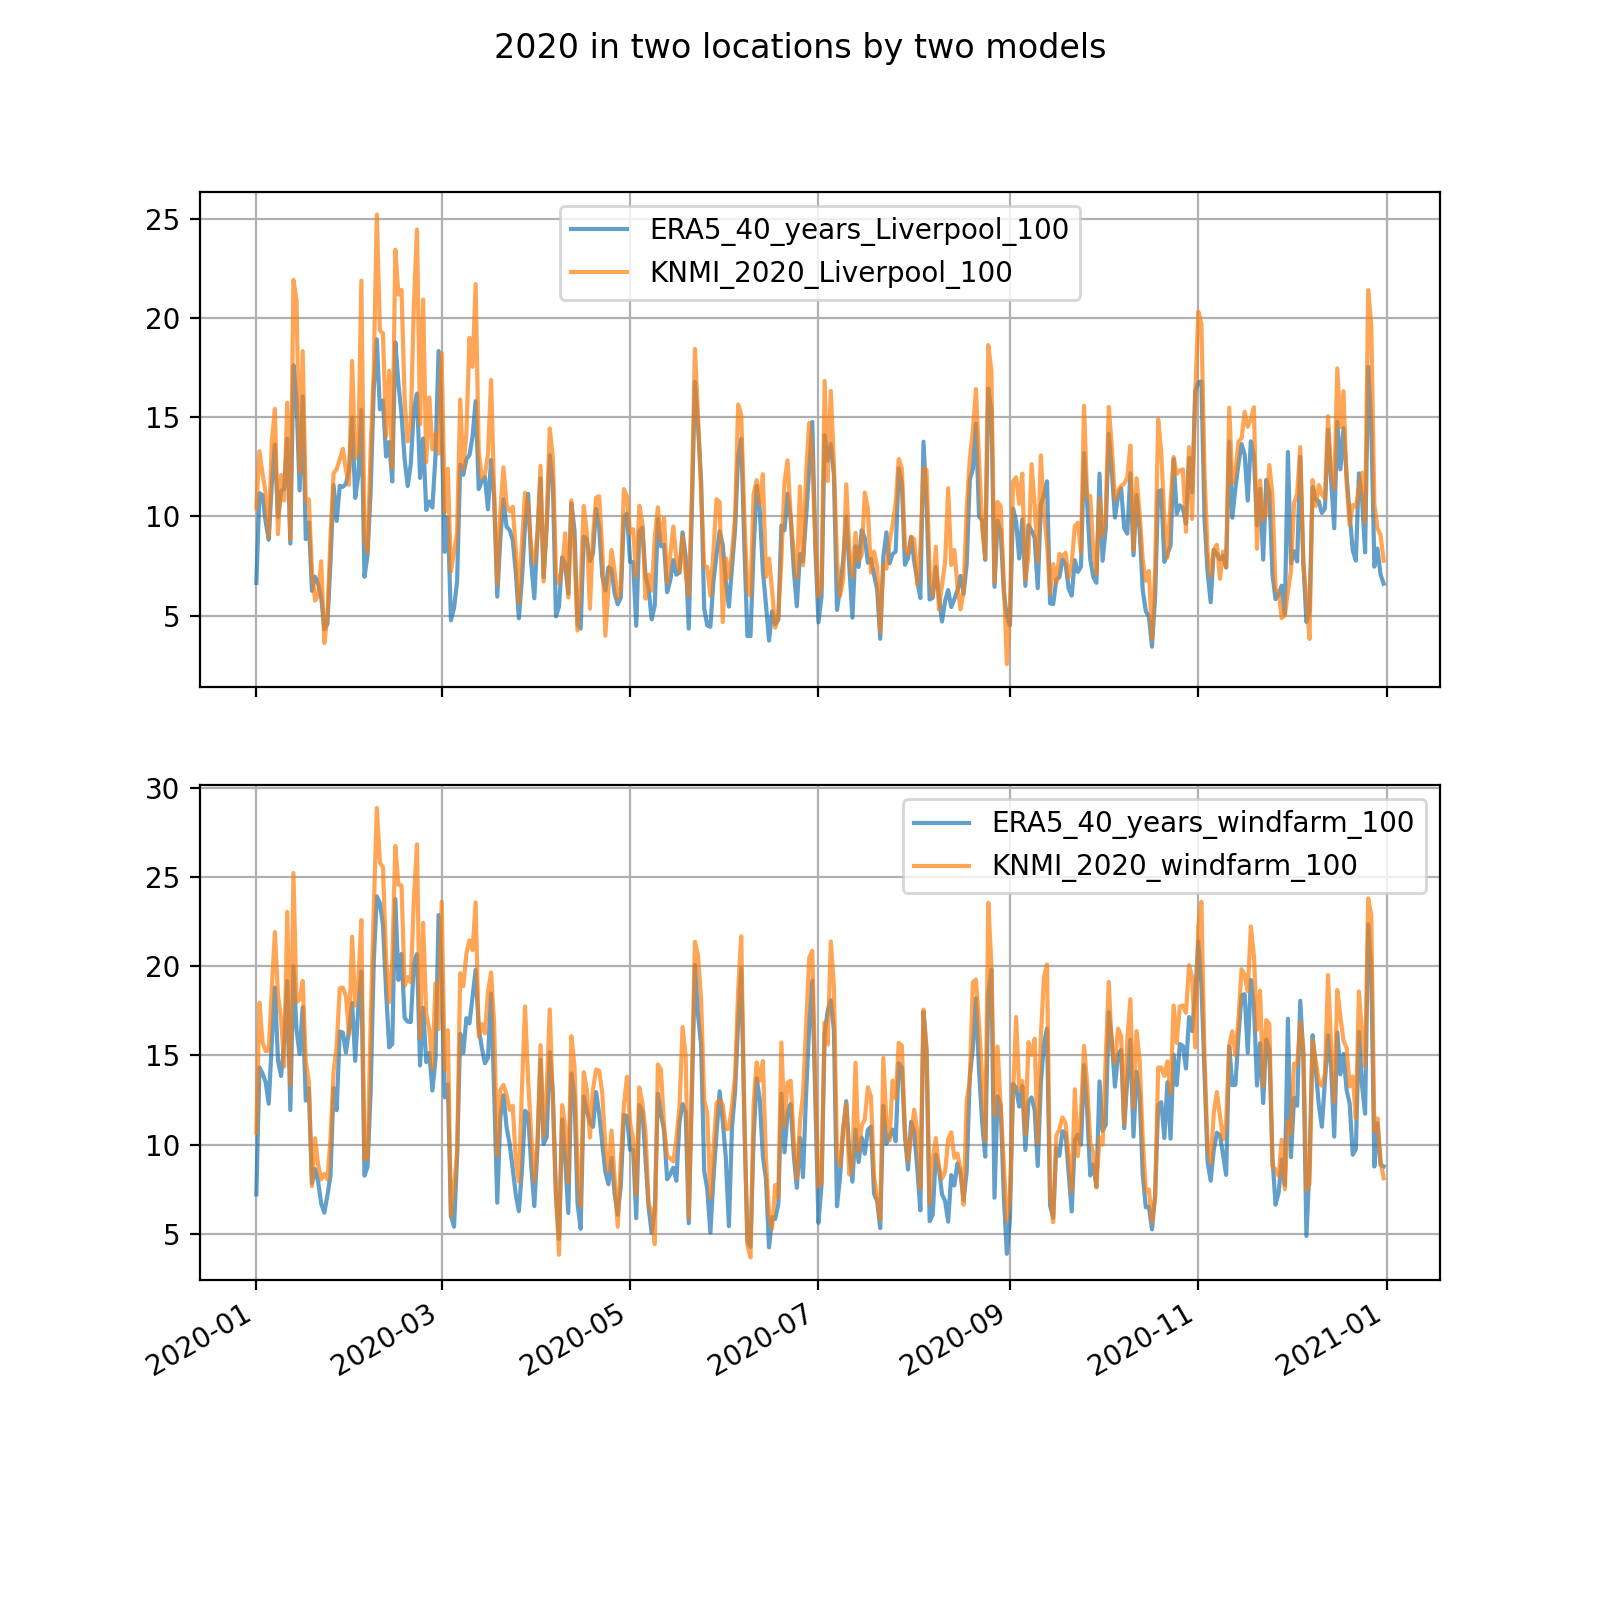

In [23]:
fig, ax = plt.subplots(2,1,figsize=(8,8))
for e,st in enumerate(ERA5_keys):
    era5_2020 = ERA5_dmax[st][ERA5_dmax[st].index.year==2020]
    ax[e].plot(era5_2020['wind_speed_at_100_metres'], label=st+'_100', alpha=0.7)
    knmi_2020 = KNMI_dmax[KNMI_keys[e]][KNMI_dmax[KNMI_keys[e]]['z']==100]['wind_speed']
    ax[e].plot(knmi_2020, label=KNMI_keys[e]+'_100',alpha=0.7)
    ax[e].legend()
    ax[e].grid()
fig.autofmt_xdate()
fig.suptitle("2020 in two locations by two models")
plt.savefig("presentation_knmi_vs_ERA5", bbox_inches='tight', transparent=True)

In the scatter plots below, we see a clear and systematic difference between the models:
1. KNMI has larger values for stronger winds in all cases
2. Difference is bigger at 10 m height and over land.

<IPython.core.display.Javascript object>


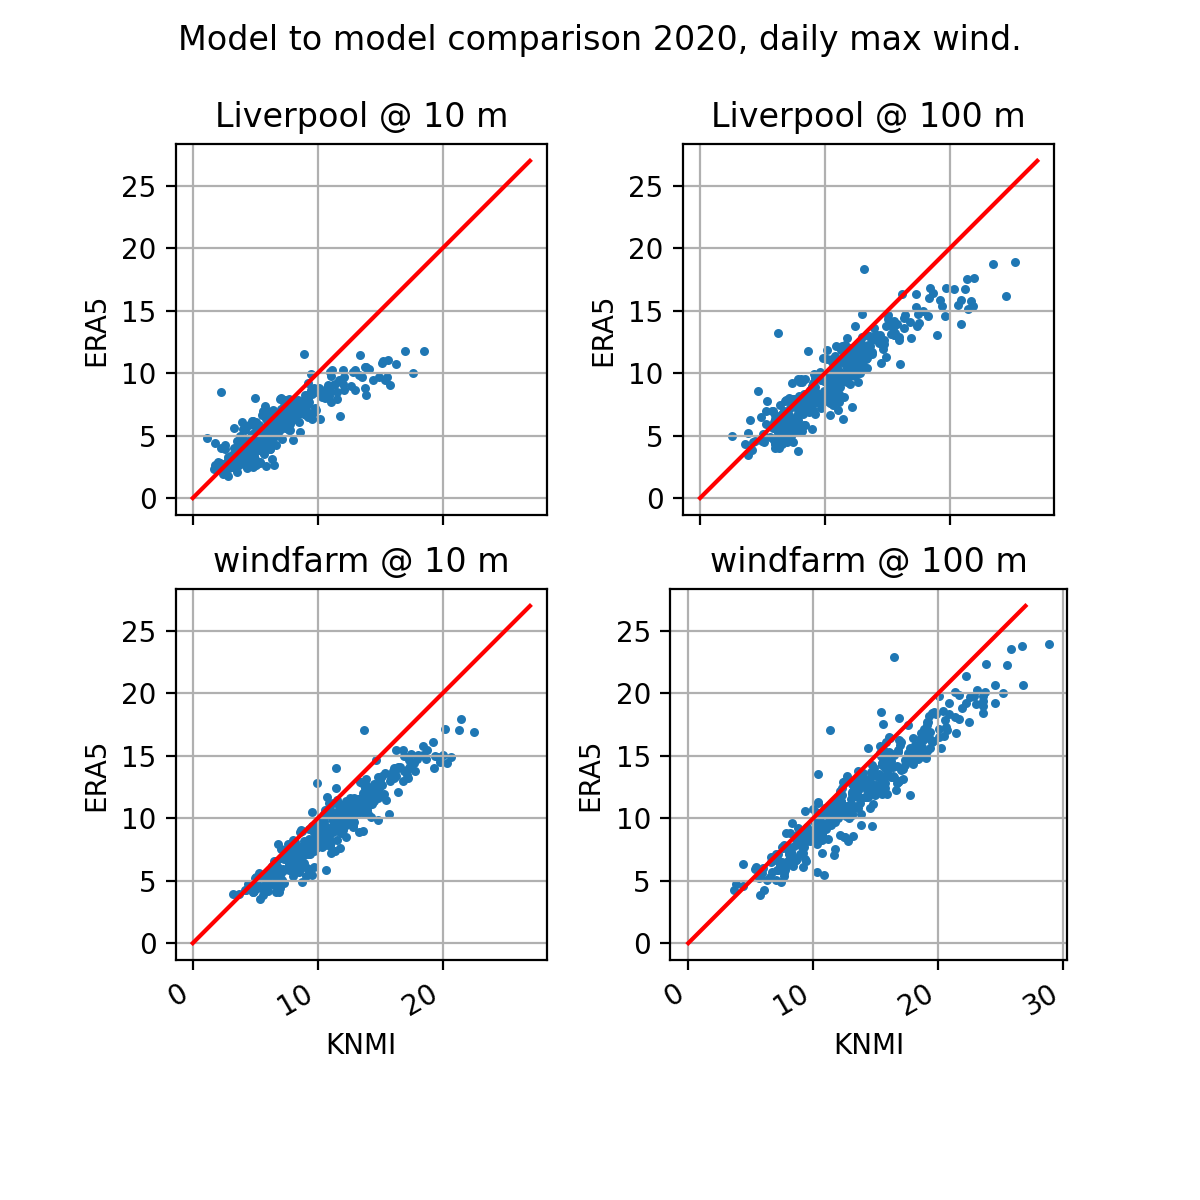

In [24]:
fig, ax = plt.subplots(2,2,figsize=(6,6))
x=np.arange(28)
for e,st in enumerate(ERA5_keys):
    for ee, level in enumerate([10,100]):
        era5_2020 = ERA5_dmax[st][ERA5_dmax[st].index.year==2020]['wind_speed_at_{}_metres'.format(level)]
        knmi_2020 = KNMI_dmax[KNMI_keys[e]][KNMI_dmax[KNMI_keys[e]]['z']==level]['wind_speed']
        ax[e,ee].scatter(knmi_2020,era5_2020, s=5)
        ax[e,ee].set_xlabel('KNMI')
        ax[e,ee].set_ylabel('ERA5')
        ax[e,ee].plot(x, x, 'r')
        ax[e,ee].set_aspect('equal', 'box')
        ax[e,ee].grid()
        ax[e,ee].title.set_text(ERA5_keys[e].split('_')[-1]+" @ {} m".format(level))
fig.autofmt_xdate()
fig.suptitle("Model to model comparison 2020, daily max wind.")
plt.savefig("presentation_model_difference_scatter_2020", bbox_inches='tight',transparent=True)

### 10 meter data vs observations

While there are systemtic differences between the two models, we have no proof, which one is actually better. Fortunately, we have observations for 10 m wind speed at Liverpool.

<IPython.core.display.Javascript object>


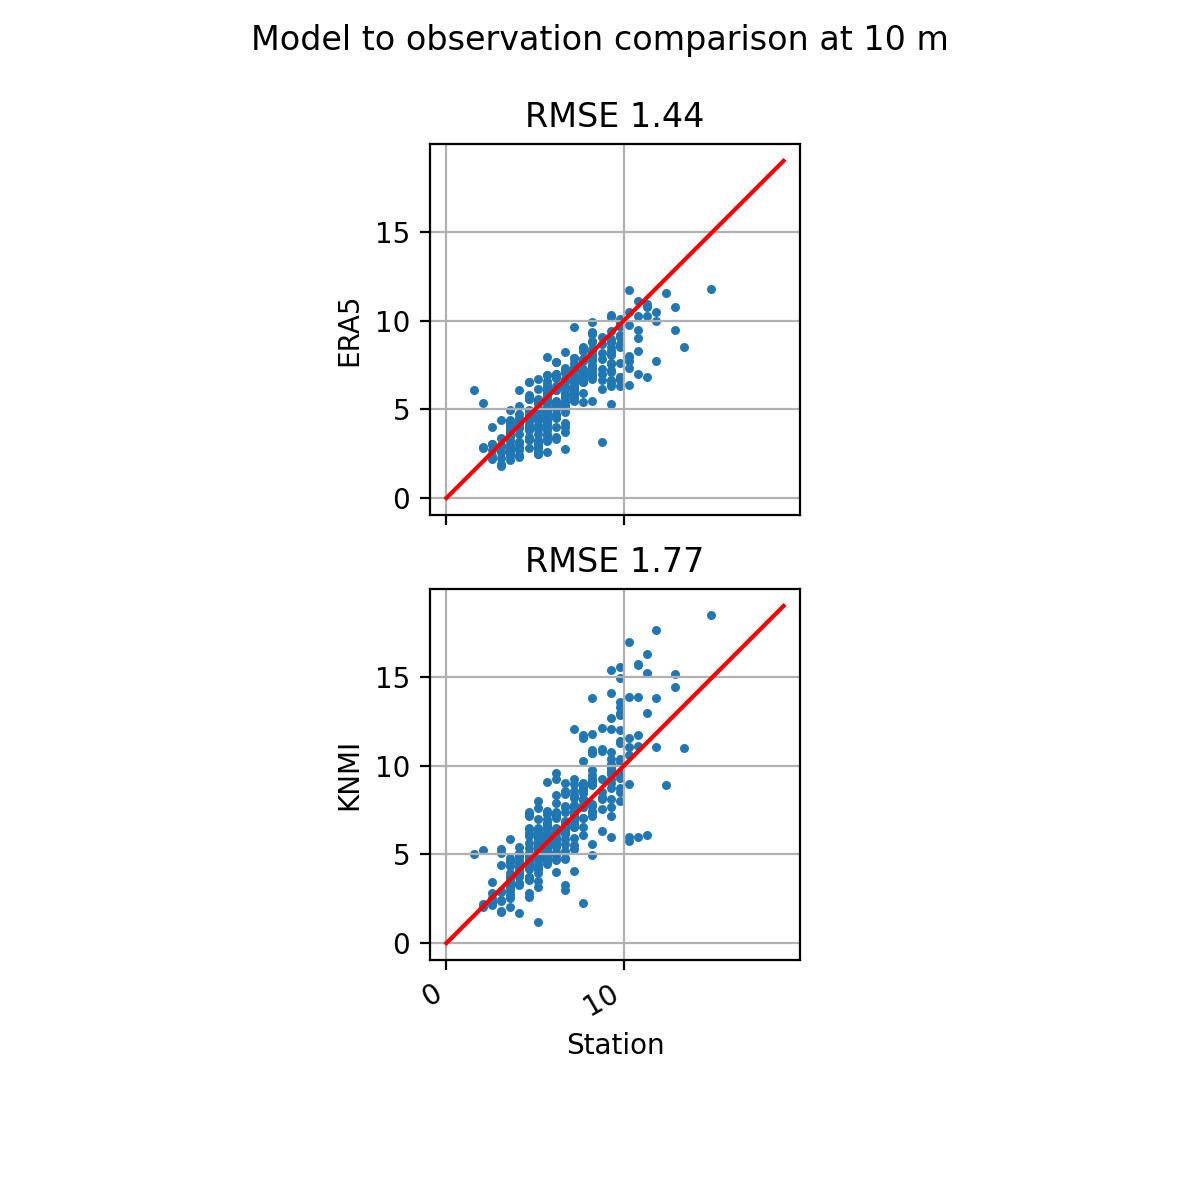

In [25]:
def rmse(x, y):
    return np.sqrt(((x-y)**2).mean())
fig, ax = plt.subplots(2,1,figsize=(6,6))
x=np.arange(20)

era5_2020 = ERA5_dmax[ERA5_keys[0]][ERA5_dmax[ERA5_keys[0]].index.year==2020]['wind_speed_at_10_metres']
knmi_2020 = KNMI_dmax[KNMI_keys[0]][KNMI_dmax[KNMI_keys[0]]['z']==10]['wind_speed']
ax[0].scatter(rbsn_data_daily,era5_2020,s=5)
ax[0].set_xlabel('Station')
ax[0].set_ylabel('ERA5')
ax[0].plot(x,x,'r')
ax[0].set_aspect('equal', 'box')
ax[0].grid()
ax[0].title.set_text("RMSE {0:2.2f}".format(rmse(rbsn_data_daily,era5_2020)))

ax[1].scatter(rbsn_data_daily,knmi_2020,s=5)
ax[1].set_xlabel('Station')
ax[1].set_ylabel('KNMI')
ax[1].plot(x,x,'r')
ax[1].set_aspect('equal', 'box')
ax[1].grid()
ax[1].title.set_text("RMSE {0:2.2f}".format(rmse(rbsn_data_daily,knmi_2020)))
fig.autofmt_xdate()
fig.suptitle("Model to observation comparison at 10 m")
plt.savefig("presentation_model_to_obs_scatter", bbox_inches='tight',transparent=True)

### Weibull distribution
Next we will look into wind distribution using Weibull fit. 

Weibull, or some other statistical distribution, is often used as a first approximation to the expected wind distribution, though it does not necessarily represent the extreme values well.

<IPython.core.display.Javascript object>


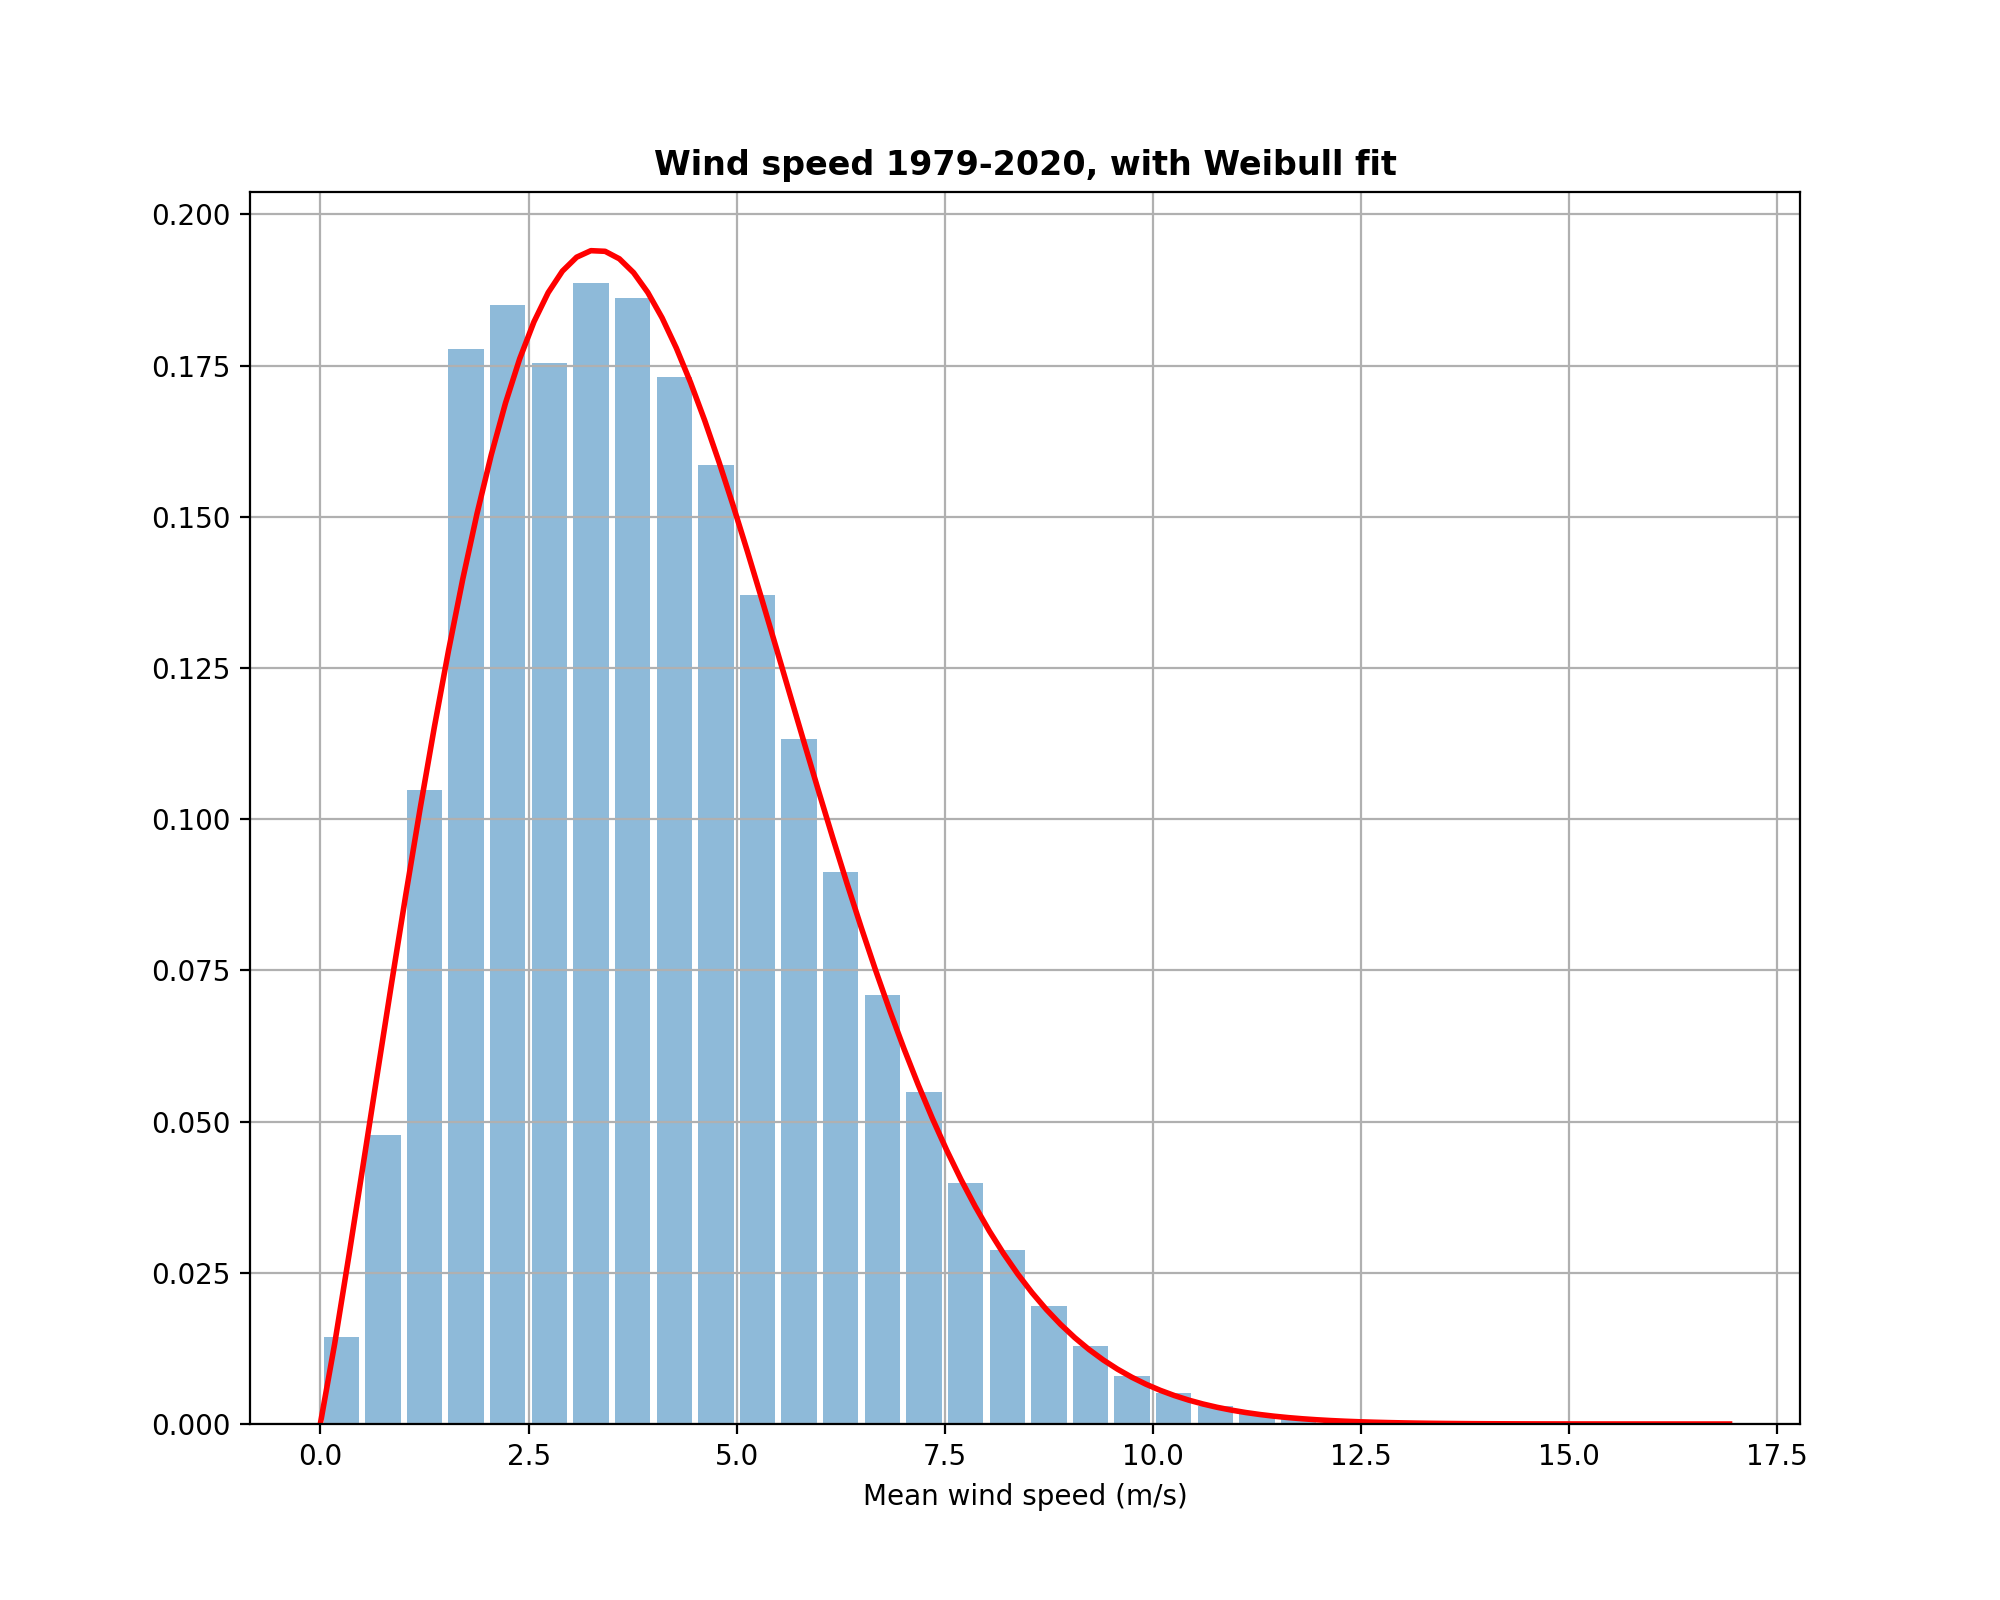

In [91]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
wind = ERA5['ERA5_40_years_Liverpool']['wind_speed_at_10_metres'].values
p0, p1, p2 = scipy.stats.weibull_min.fit(wind)
bins = np.arange(0, np.amax(wind), 0.5)
ax.hist(wind, bins=bins, density=True, alpha=0.5,rwidth=0.85)
support = np.linspace(wind.min(), 
                     wind.max(), 100)
ax.plot(support, scipy.stats.weibull_min.pdf(support, p0, p1, p2), "r-", lw=2)
plt.title("Wind speed 1979-2020, with Weibull fit", weight="bold")
plt.xlabel("Mean wind speed (m/s)");
plt.grid()
plt.show()

In [132]:
knmi_2020_10m_wind = KNMI['KNMI_2020_Liverpool']['wind_speed'].where(KNMI['KNMI_2020_Liverpool']['z']==10)
era5_2020_10m_wind = ERA5['ERA5_40_years_Liverpool']['wind_speed_at_10_metres'].loc[ERA5['ERA5_40_years_Liverpool'].index.year == 2020]

<IPython.core.display.Javascript object>


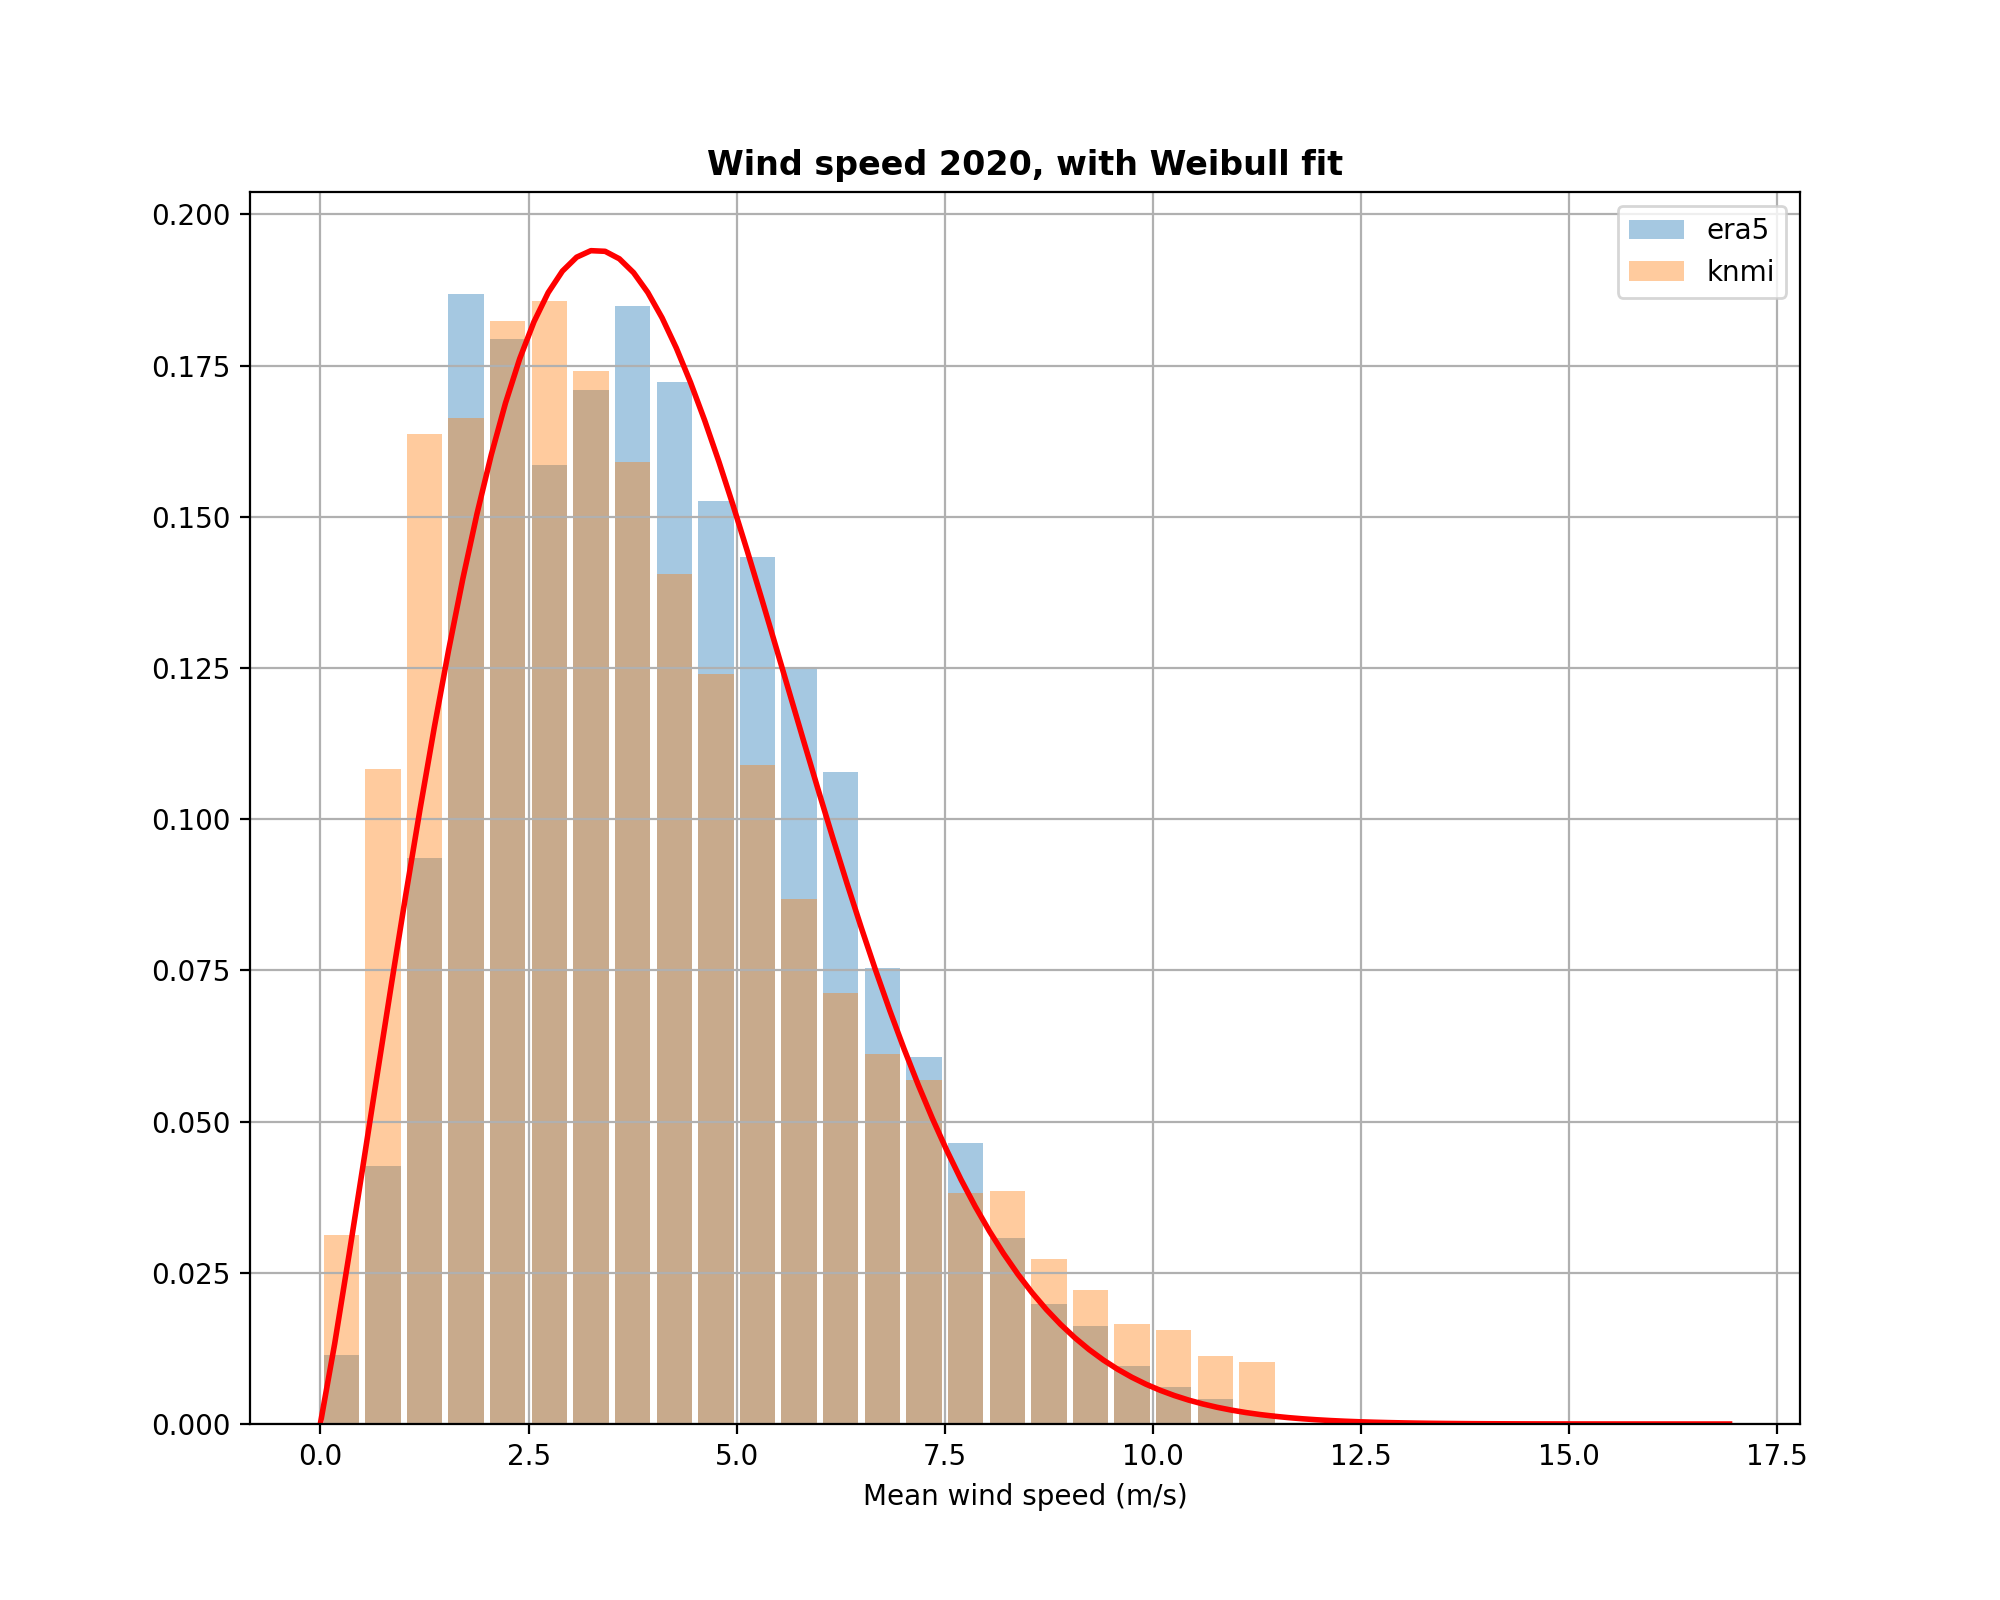

In [135]:
# 2020 data for both knmi and era5 compared to weibull
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

#p0, p1, p2 = scipy.stats.weibull_min.fit(dd_era5['wind_speed_at_100_metres'], floc=0)
bins = np.arange(0, np.amax(era5_2020_10m_wind), 0.5)
ax.hist(
    era5_2020_10m_wind, 
    bins=bins, 
    density=True, 
    alpha=0.4,
    rwidth=0.85,
    label='era5')
ax.hist(
    knmi_2020_10m_wind, 
    bins=bins, 
    density=True, 
    alpha=0.4,
    rwidth=0.85,
    label='knmi')

plt.legend()
ax.plot(support, scipy.stats.weibull_min.pdf(support, p0, p1, p2), "r-", lw=2)
plt.title("Wind speed 2020, with Weibull fit", weight="bold")
plt.xlabel("Mean wind speed (m/s)");
plt.grid()
plt.savefig('/home/etoodu/tst.png')
plt.show()